# Membuat Model Sistem Rekomendasi (Content-Based Filtering) Menggunakan Dataset Dari [TMDB Movies Dataset](https://www.kaggle.com/datasets/ahsanaseer/top-rated-tmdb-movies-10k/data)

- **Nama:** Fahru Rahman
- **Email:** fhrurhmn@gmail.com
- **ID Dicoding:** mc009d5y0506

# Import Library Yang Dibutuhkan

In [48]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import os
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

# Data Loading

In [49]:
# upload dataset
file_path = '/content/top10K-TMDB-movies.csv'
if os.path.exists(file_path):
    print(f"File {file_path} ditemukan di session storage.")
    df = pd.read_csv(file_path)
else:
    print("File tidak ditemukan. Silakan unggah file top10K-TMDB-movies.csv")
    uploaded = files.upload()
    df = pd.read_csv('top10K-TMDB-movies.csv')

File /content/top10K-TMDB-movies.csv ditemukan di session storage.


In [50]:
df.head()

,id,title,genre,original_language,overview,popularity,release_date,vote_average,vote_count
0,278,The Shawshank Redemption,"Drama,Crime",en,Framed in the 1940s for the double murder of h...,94.075,1994-09-23,8.7,21862
1,19404,Dilwale Dulhania Le Jayenge,"Comedy,Drama,Romance",hi,"Raj is a rich, carefree, happy-go-lucky second...",25.408,1995-10-19,8.7,3731
2,238,The Godfather,"Drama,Crime",en,"Spanning the years 1945 to 1955, a chronicle o...",90.585,1972-03-14,8.7,16280
3,424,Schindler's List,"Drama,History,War",en,The true story of how businessman Oskar Schind...,44.761,1993-12-15,8.6,12959
4,240,The Godfather: Part II,"Drama,Crime",en,In the continuing saga of the Corleone crime f...,57.749,1974-12-20,8.6,9811


>menampilkan informasi dataset

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10000 non-null  int64  
 1   title              10000 non-null  object 
 2   genre              9997 non-null   object 
 3   original_language  10000 non-null  object 
 4   overview           9987 non-null   object 
 5   popularity         10000 non-null  float64
 6   release_date       10000 non-null  object 
 7   vote_average       10000 non-null  float64
 8   vote_count         10000 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 703.3+ KB


> mengecek missing value pada setiap kolom

In [52]:
print("\nJumlah Nilai Kosong per Kolom:")
print(df.isnull().sum())


Jumlah Nilai Kosong per Kolom:
id                    0
title                 0
genre                 3
original_language     0
overview             13
popularity            0
release_date          0
vote_average          0
vote_count            0
dtype: int64


> mengecek data duplikat

In [53]:
print("\nJumlah Duplicated:")
print(df.duplicated().sum())


Jumlah Duplicated:
0


# EDA

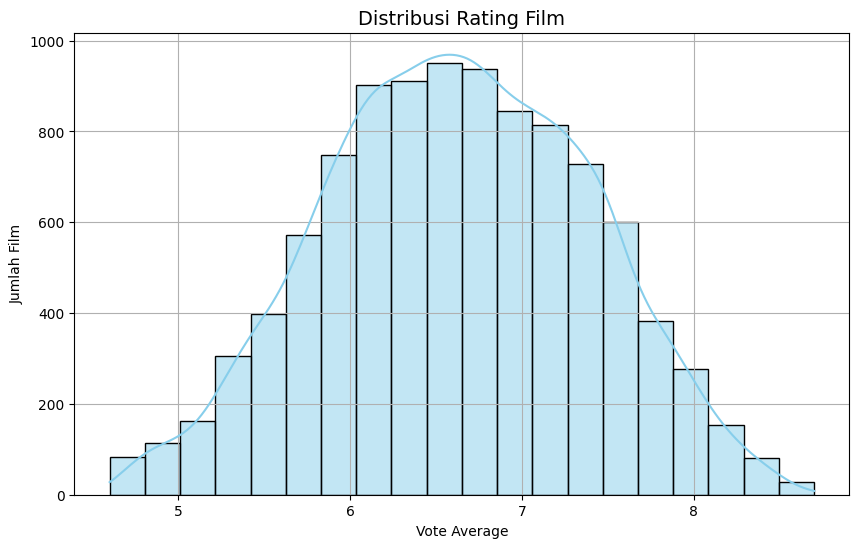

In [54]:
# Plot distribusi rating
plt.figure(figsize=(10, 6))
sns.histplot(df['vote_average'], bins=20, kde=True, color='skyblue')
plt.title('Distribusi Rating Film', fontsize=14)
plt.xlabel('Vote Average')
plt.ylabel('Jumlah Film')
plt.grid(True)
plt.show()

> Terlihat bahwa rata rata film memiliki rating 6.5 hingga 7.5 yang mencerminkan dataset berisi film film yang cukup bagus

<ipython-input-55-c134d8ea6f7b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_df.head(10), x='Jumlah', y='Genre', palette='viridis')


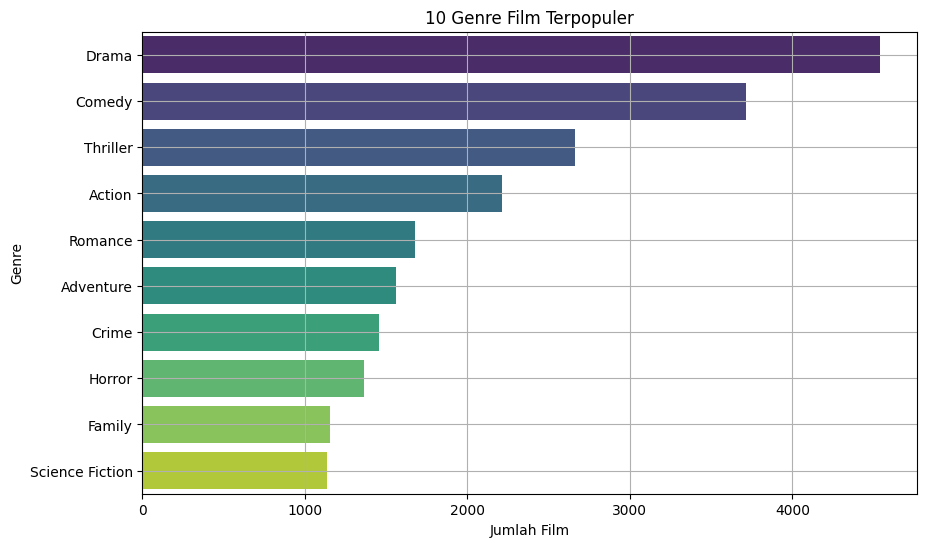

In [55]:
# Pisahkan genre
genre_split = df['genre'].dropna().apply(lambda x: x.split(','))
genre_counts = Counter([g.strip() for sublist in genre_split for g in sublist])
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Jumlah']).sort_values(by='Jumlah', ascending=False)

# Plot 10 genre terpopuler
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_df.head(10), x='Jumlah', y='Genre', palette='viridis')
plt.title('10 Genre Film Terpopuler')
plt.xlabel('Jumlah Film')
plt.ylabel('Genre')
plt.grid(True)
plt.show()

> terlihat dari grafik tersebut bahwa genre film yang terpopuler adalah drama, diikuti oleh comedy dan thriller

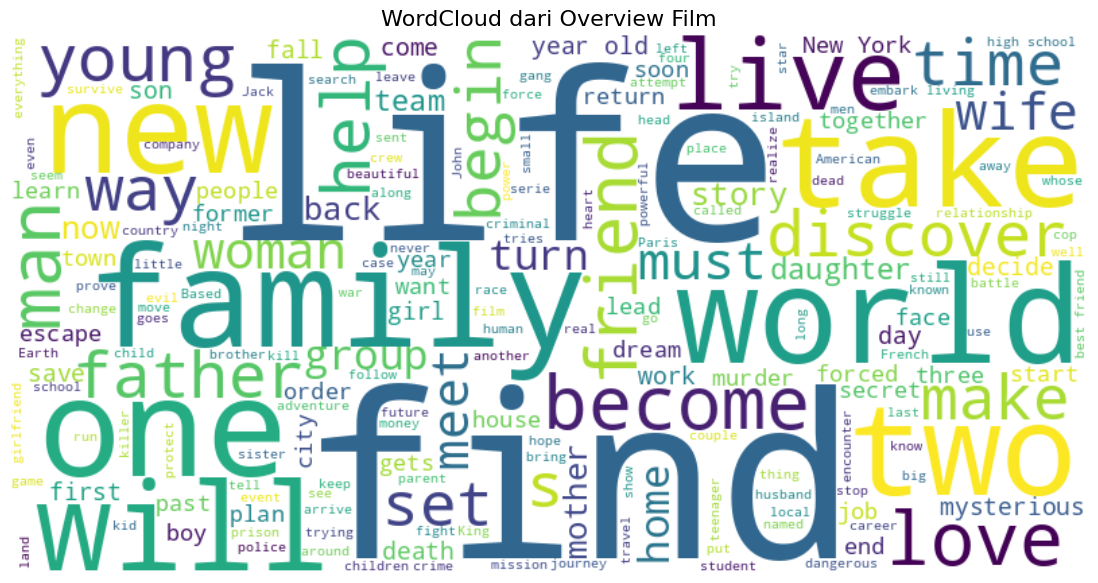

In [56]:
# Gabungkan semua overview
text = ' '.join(df['overview'].dropna().tolist())

# Buat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dari Overview Film', fontsize=16)
plt.show()

# Data Pre-Processing

In [57]:
df['overview'] = df['overview'].fillna('')
df['genre'] = df['genre'].fillna('')
print("\nJumlah Nilai Kosong Setelah Pengisian:")
print(df.isnull().sum())


Jumlah Nilai Kosong Setelah Pengisian:
id                   0
title                0
genre                0
original_language    0
overview             0
popularity           0
release_date         0
vote_average         0
vote_count           0
dtype: int64




> Mengisi nilai kosong dengan string kosong lebih baik daripada menghapus baris karena memungkinkan semua 10.000 film tetap ada dalam sistem rekomendasi tanpa kehilangan film yang mungkin relevan.



In [58]:
# menggabungkan genre dan overview
df['combined_features'] = df['genre'] + ' ' + df['overview']

# menampilkan 5 baris pertama dari kolom baru
display(df[['title', 'combined_features']].head())

,title,combined_features
0,The Shawshank Redemption,"Drama,Crime Framed in the 1940s for the double..."
1,Dilwale Dulhania Le Jayenge,"Comedy,Drama,Romance Raj is a rich, carefree, ..."
2,The Godfather,"Drama,Crime Spanning the years 1945 to 1955, a..."
3,Schindler's List,"Drama,History,War The true story of how busine..."
4,The Godfather: Part II,"Drama,Crime In the continuing saga of the Corl..."




> Kolom genre dan overview digabung agar sistem rekomendasi bisa lebih akurat mengenali kemiripan film berdasarkan tema dan deskripsi ceritanya.



In [59]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])
print("\nUkuran Matriks TF-IDF:", tfidf_matrix.shape)


Ukuran Matriks TF-IDF: (10000, 27965)




> TF-IDF mengubah teks menjadi angka agar sistem rekomendasi bisa mengukur kemiripan antar film berdasarkan kata-kata penting.



# Modelling

In [60]:
# Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("\nUkuran Matriks Cosine Similarity:", cosine_sim.shape)
print("\nContoh Skor Kemiripan untuk Film Pertama:")
print(cosine_sim[0][:5])


Ukuran Matriks Cosine Similarity: (10000, 10000)

Contoh Skor Kemiripan untuk Film Pertama:
[1.         0.00978111 0.02126145 0.00269654 0.01663191]


In [61]:
# Ubah cosine similarity ke DataFrame
cosine_sim_df = pd.DataFrame(
    cosine_sim,
    index=df['title'],   # baris: judul film
    columns=df['title']  # kolom: judul film
)

# Tampilkan 5 baris pertama sebagai sampel
print("\nContoh DataFrame Cosine Similarity:")
cosine_sim_df.iloc[:5, :5]


Contoh DataFrame Cosine Similarity:


title,The Shawshank Redemption,Dilwale Dulhania Le Jayenge,The Godfather,Schindler's List,The Godfather: Part II
title,,,,,
The Shawshank Redemption,1.000000,0.009781,0.021261,0.002697,0.016632
Dilwale Dulhania Le Jayenge,0.009781,1.000000,0.008774,0.002347,0.038124
The Godfather,0.021261,0.008774,1.000000,0.003062,0.429647
Schindler's List,0.002697,0.002347,0.003062,1.000000,0.002969
The Godfather: Part II,0.016632,0.038124,0.429647,0.002969,1.000000




> Pada tahap cosine similarity, kemiripan antar film dihitung dengan mengukur sudut antara vektor TF-IDF masing-masing film, menghasilkan matriks 10.000 x 10.000 yang menunjukkan seberapa mirip setiap pasangan film berdasarkan konten teksnya.



# Fungsi Rekomendasi

In [62]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Mengecek apakah judul film yang diminta ada di dataset
    if title not in df['title'].values:
        return f"Film {title} tidak ditemukan di dataset."

    # Mengambil index dari film yang sesuai dengan judul
    idx = df[df['title'] == title].index[0]

    # Mengambil skor kemiripan (cosine similarity) antara film tersebut dengan semua film lain
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Mengurutkan daftar skor kemiripan dari yang paling tinggi ke paling rendah
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Mengambil 10 film teratas dengan kemiripan tertinggi, kecuali film itu sendiri (urutan pertama)
    sim_scores = sim_scores[1:11]

    # Mengambil index dari 10 film yang paling mirip
    movie_indices = [i[0] for i in sim_scores]

    # Mengambil nilai skor kemiripan dari 10 film tersebut
    similarity_scores = [i[1] for i in sim_scores]

    # Mengambil informasi judul, genre, dan rating dari film-film rekomendasi
    result = df[['title', 'genre', 'vote_average']].iloc[movie_indices].copy()

    # Menambahkan kolom skor kemiripan ke DataFrame hasil rekomendasi
    result['similarity_score'] = similarity_scores

    # Mengembalikan DataFrame berisi 10 film rekomendasi beserta skor kemiripannya
    return result




> Fungsi get_recommendations menerima judul film, memeriksa keberadaannya di dataset, lalu mengembalikan 10 film paling mirip berdasarkan skor cosine similarity dari matriks TF-IDF, dengan menampilkan judul, genre, dan rating rata-rata.



In [63]:
# menguji rekomendasi
test_titles = ['Midsommar', 'RoboCop', 'Parasite']
for title in test_titles:
    print(f"\nRekomendasi untuk '{title}':")
    display(get_recommendations(title))


Rekomendasi untuk 'Midsommar':


,title,genre,vote_average,similarity_score
6110,The Experiment,"Thriller,Drama",6.4,0.140349
8486,He's Out There,"Horror,Thriller",5.8,0.134374
7880,No One Gets Out Alive,"Horror,Thriller,Mystery",6.0,0.128938
8496,A Christmas Horror Story,"Horror,Fantasy",5.8,0.119459
5961,Aftermath,"Horror,Crime,Drama,Thriller",6.4,0.119332
6798,The Crazies,"Mystery,Horror,Action",6.2,0.117672
7398,Don't Hang Up,"Horror,Thriller",6.1,0.116842
2104,Munna Bhai M.B.B.S.,"Comedy,Drama",7.3,0.116446
7268,The Children,"Horror,Mystery,Thriller",6.1,0.115768
6511,The Visit,"Horror,Thriller,Mystery",6.3,0.113543



Rekomendasi untuk 'RoboCop':


,title,genre,vote_average,similarity_score
9967,RoboCop 3,"Action,Adventure,Crime,Science Fiction,Thriller",4.7,0.292440
8403,RoboCop,"Science Fiction,Action",5.8,0.177102
7999,RoboCop 2,"Action,Adventure,Crime,Science Fiction,Thriller",5.9,0.133381
9194,Coffee & Kareem,"Comedy,Action,Crime",5.5,0.127443
7783,Cobra,"Action,Crime,Thriller",6.0,0.126506
7290,Resident Evil: Welcome to Raccoon City,"Horror,Action,Science Fiction",6.1,0.108792
9615,How It Ends,"Science Fiction,Thriller,Mystery,Action,Adventure",5.3,0.107706
5484,Monsters of Man,Science Fiction,6.5,0.106853
9605,Home Alone 3,"Comedy,Family",5.3,0.106329
3212,Strange Days,"Crime,Drama,Science Fiction,Thriller",7.0,0.106303



Rekomendasi untuk 'Parasite':


,title,genre,vote_average,similarity_score
104,Bicycle Thieves,Drama,8.3,0.195468
2563,The China Syndrome,"Drama,Thriller",7.2,0.147125
3612,Crime Busters,"Action,Comedy",6.9,0.130952
9825,Bar Sport,"Comedy,Family",5.0,0.126490
7380,Forgive Us Our Debts,Drama,6.1,0.122516
9755,A Wrinkle in Time,"Adventure,Science Fiction,Family,Fantasy",5.1,0.118626
9417,Absolutely Fabulous: The Movie,Comedy,5.4,0.117171
89,Mommy,Drama,8.3,0.113036
7367,Home Again,"Comedy,Drama,Romance",6.1,0.112202
9939,I Want You,"Romance,Comedy",4.8,0.112126


# Evaluasi

### Fungsi untuk menghitung precision@k secara otomatis

In [64]:
def calculate_precision_at_k(recommended_movies, relevant_movies, k):
    # Ambil K item teratas dari rekomendasi
    top_k = recommended_movies[:k]

    # Hitung jumlah item relevan dalam top-K
    relevant_in_top_k = len(set(top_k) & set(relevant_movies))

    # Hitung Precision@K
    precision = relevant_in_top_k / k if k > 0 else 0

    return precision

In [65]:
def evaluate_recommendations(movie_title, df, k=10):
    # Dapatkan rekomendasi dari fungsi get_recommendations
    recommendations = get_recommendations(movie_title)
    recommended_titles = recommendations['title'].tolist()

    # Film relevan adalah film dengan genre yang sama dengan film input
    movie_genre = df[df['title'] == movie_title]['genre'].iloc[0].split(',')
    relevant_movies = df[df['genre'].apply(lambda x: any(g in x for g in movie_genre))]['title'].tolist()

    # Hitung Precision@K
    precision = calculate_precision_at_k(recommended_titles, relevant_movies, k)
    print(f"Precision@{k} untuk '{movie_title}': {precision:.2f}")
    return precision

precision = evaluate_recommendations('Midsommar', df, k=10)
precision = evaluate_recommendations('RoboCop', df, k=10)
precision = evaluate_recommendations('Parasite', df, k=10)

Precision@10 untuk 'Midsommar': 1.00
Precision@10 untuk 'RoboCop': 0.90
Precision@10 untuk 'Parasite': 0.90
